# Phase 1: Data Loading & Cleaning
**Objective:** Prepare the raw Telco dataset for analysis by fixing data types and handling missing values.

### 1.1 Load Libraries & Dataset
First, we import the necessary libraries for data manipulation (Pandas, NumPy) and visualization (Matplotlib, Seaborn). We then load the dataset to begin our inspection.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display the first 5 rows to verify loading
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1.2 Data Cleaning: The `TotalCharges` Fix
**Critical Issue:** The `TotalCharges` column is initially read as an `object` (string) because it contains blank strings (`" "`) for customers with 0 tenure. If ignored, this predictive feature would be treated as categorical.

**Action:**
1. Force-convert `TotalCharges` to numeric, turning errors into `NaN`.
2. Identify and count these missing values.
3. Impute `NaN` with `0`, as these customers have not yet been charged.

In [2]:
# Force convert to numeric, turning errors (blank strings) into NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check how many missing values we created (these were the blank strings)
missing_count = df['TotalCharges'].isnull().sum()
print(f"Missing values in TotalCharges: {missing_count}")


Missing values in TotalCharges: 11


### Data Cleaning – Fix TotalCharges properly

Filling missing TotalCharges with 0 creates artificial extreme values.
Instead, we use median imputation to avoid bias.



In [3]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())


### 1.3 Feature Standardization & Cleanup
To make the dataset consistent for analysis:
* **`SeniorCitizen`**: Converted from `0/1` integers to `No/Yes` to match other categorical columns.
* **`customerID`**: Dropped as it is a unique identifier with no predictive value.

In [4]:
# Convert SeniorCitizen to string for consistency
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# Drop customerID
df.drop(columns=['customerID'], errors='ignore', inplace=True)


### 1.4 Sanity Check & Class Distribution
Before proceeding to EDA, we verify the data types and check for **Class Imbalance**.

**Why check imbalance?**
If the "No Churn" class dominates (e.g., >70%), we cannot rely solely on accuracy metrics. We will need techniques like SMOTE or Class Weighting in later phases.

In [5]:
# Check for Class Imbalance
churn_rate = df['Churn'].value_counts(normalize=True)
print("Class Distribution:")
print(churn_rate)

# Display info to confirm types are correct
print("\nFinal Data Types:")
print(df.dtypes)

Class Distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

Final Data Types:
gender                  str
SeniorCitizen           str
Partner                 str
Dependents              str
tenure                int64
PhoneService            str
MultipleLines           str
InternetService         str
OnlineSecurity          str
OnlineBackup            str
DeviceProtection        str
TechSupport             str
StreamingTV             str
StreamingMovies         str
Contract                str
PaperlessBilling        str
PaymentMethod           str
MonthlyCharges      float64
TotalCharges        float64
Churn                   str
dtype: object


In [6]:
# Average monthly spend
df['AvgCharge'] = df['TotalCharges'] / (df['tenure'] + 1)

# New customers more likely to churn
df['IsNewCustomer'] = (df['tenure'] < 6).astype(int)

# Contract loyalty
df['HasContract'] = (df['Contract'] != 'Month-to-month').astype(int)

# Number of services subscribed
service_cols = [
    'PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
    'DeviceProtection','TechSupport','StreamingTV','StreamingMovies'
]

df['NumServices'] = (df[service_cols] == 'Yes').sum(axis=1)

print("New features created:")
print(df[['AvgCharge', 'IsNewCustomer', 'HasContract', 'NumServices']].head())

New features created:
   AvgCharge  IsNewCustomer  HasContract  NumServices
0  14.925000              1            0            1
1  53.985714              0            1            3
2  36.050000              1            0            3
3  40.016304              0            1            3
4  50.550000              1            0            1


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Encode Target (Churn)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Define Features (X) and Target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

print(f"Numeric columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")

# Create preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nTraining shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing shapes: {X_test.shape}, {y_test.shape}")

Numeric columns: ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgCharge', 'IsNewCustomer', 'HasContract', 'NumServices']
Categorical columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Training shapes: (5634, 23), (5634,)
Testing shapes: (1409, 23), (1409,)


I:\Temp\ipykernel_23848\3424973758.py:15: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X.select_dtypes(include='object').columns.tolist()


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

log_model = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))
])

log_model.fit(X_train, y_train)

pred_log = log_model.predict(X_test)

print("=== Baseline Logistic Regression ===")
print(classification_report(y_test, pred_log))

=== Baseline Logistic Regression ===
              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1035
           1       0.51      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



In [9]:
from xgboost import XGBClassifier

# Calculate class weight
neg, pos = np.bincount(y_train)
weight = neg / pos

print(f"Class weight: {weight:.2f}")

xgb_model = Pipeline([
    ('prep', preprocessor),
    ('model', XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=weight,
        eval_metric='auc',
        random_state=42,
        use_label_encoder=False
    ))
])

xgb_model.fit(X_train, y_train)

pred_xgb = xgb_model.predict(X_test)

print("\n=== XGBoost Model ===")
print(classification_report(y_test, pred_xgb))

Class weight: 2.77


i:\Project\ICSSR_Telco_Customer_Churn\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [21:08:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost Model ===
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1035
           1       0.53      0.76      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409



In [10]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_log = cross_val_score(log_model, X, y, cv=cv, scoring='roc_auc')
scores_xgb = cross_val_score(xgb_model, X, y, cv=cv, scoring='roc_auc')

print("=== Cross Validation Results (ROC-AUC) ===")
print(f"Logistic Regression: {scores_log.mean():.4f} (+/- {scores_log.std():.4f})")
print(f"XGBoost: {scores_xgb.mean():.4f} (+/- {scores_xgb.std():.4f})")

i:\Project\ICSSR_Telco_Customer_Churn\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [21:08:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
i:\Project\ICSSR_Telco_Customer_Churn\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [21:08:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
i:\Project\ICSSR_Telco_Customer_Churn\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [21:08:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
i:\Project\ICSSR_Telco_Customer_Churn\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [21:08:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

=== Cross Validation Results (ROC-AUC) ===
Logistic Regression: 0.8486 (+/- 0.0112)
XGBoost: 0.8417 (+/- 0.0096)


In [11]:
from sklearn.metrics import f1_score

# Get probability predictions
probs = xgb_model.predict_proba(X_test)[:, 1]

# Find optimal threshold
best_f1 = 0
best_thresh = 0.5

for t in np.arange(0.2, 0.6, 0.02):
    preds = (probs > t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold: {best_thresh:.2f}, F1-Score: {best_f1:.4f}")

Best threshold: 0.44, F1-Score: 0.6264


<Figure size 600x500 with 0 Axes>

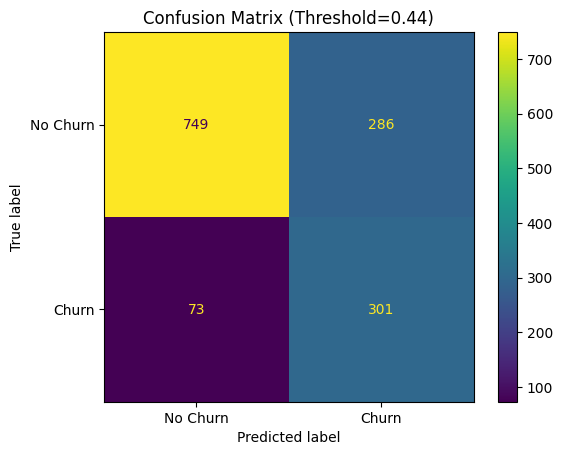

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Apply optimal threshold
preds_optimized = (probs > best_thresh).astype(int)

# Create confusion matrix
cm = confusion_matrix(y_test, preds_optimized)

plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay(cm, display_labels=['No Churn', 'Churn']).plot()
plt.title(f'Confusion Matrix (Threshold={best_thresh:.2f})')
plt.show()

i:\Project\ICSSR_Telco_Customer_Churn\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


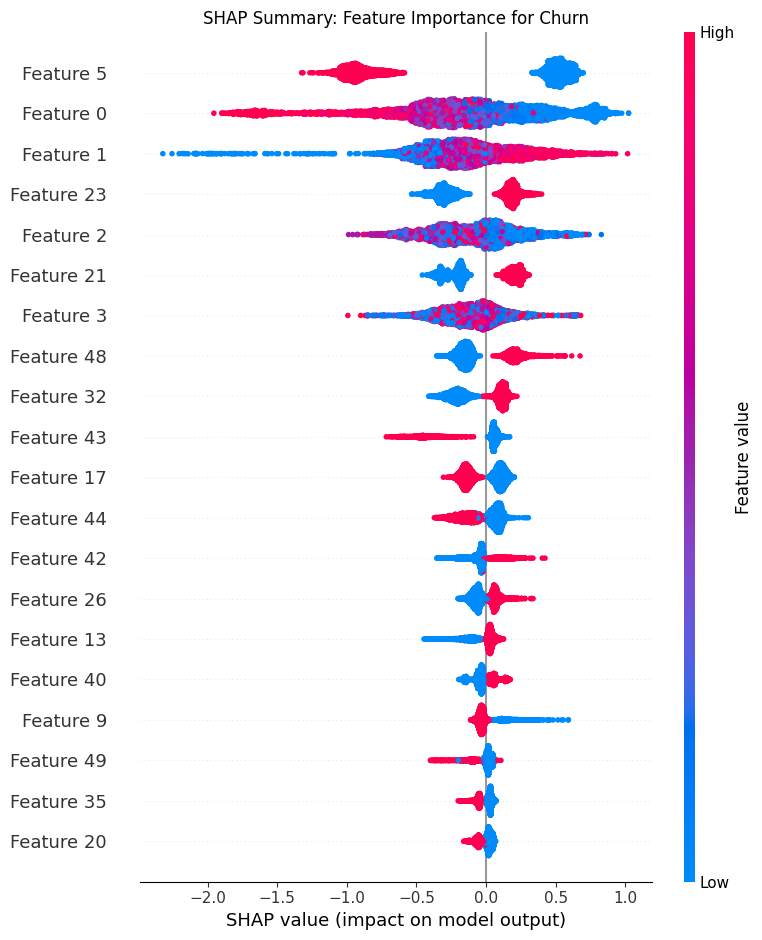

In [13]:
import shap

# Extract trained XGBoost model
model = xgb_model.named_steps['model']

# Transform features using preprocessor
X_train_transformed = xgb_model.named_steps['prep'].transform(X_train)

# Create explainer and compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_transformed)

# Plot summary
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_transformed, show=False)
plt.title('SHAP Summary: Feature Importance for Churn')
plt.tight_layout()
plt.show()

## Step 9 — Model Explainability (SHAP)

**Note:** Run `pip install shap` in a terminal if not already installed.

## Step 8 — Confusion Matrix

## Step 7 — Threshold Optimization

## Step 6 — Stratified Cross Validation

## Step 5 — XGBoost Model (Improved)

## Step 4 — Baseline Logistic Regression

## Step 3 — Professional Preprocessing Pipeline

Use ColumnTransformer instead of manual encoding for production-grade scalability.

# Step 2 — Feature Engineering

Create behavioral features to improve churn prediction.